In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.cluster import MeanShift, estimate_bandwidth

from imblearn.over_sampling import SMOTE

import time
from datetime import datetime
import sqlite3 as sql

import warnings
warnings.filterwarnings("ignore")

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
"""
url = "https://raw.githubusercontent.com/eserinanarslan/probability_prediction/main/data/dataset.csv?token=AOT2MQMPSJPFDLZ6CAQ4KILARVTBY"
data = pd.read_csv(url, delimiter=";")
df = data.copy()
df = reduce_mem_usage(df)
df.to_excel("data.xlsx", index=False)
"""
data = pd.read_excel("data.xlsx")
df = data.copy()

In [4]:
df.shape

(99976, 43)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uuid                                 99976 non-null  object 
 1   default                              89976 non-null  float64
 2   account_amount_added_12_24m          99976 non-null  int64  
 3   account_days_in_dc_12_24m            88140 non-null  float64
 4   account_days_in_rem_12_24m           88140 non-null  float64
 5   account_days_in_term_12_24m          88140 non-null  float64
 6   account_incoming_debt_vs_paid_0_24m  40661 non-null  float64
 7   account_status                       45603 non-null  float64
 8   account_worst_status_0_3m            45603 non-null  float64
 9   account_worst_status_12_24m          33215 non-null  float64
 10  account_worst_status_3_6m            42274 non-null  float64
 11  account_worst_status_6_12m  

In [6]:
df.replace("no_match", np.nan, inplace=True)
df["has_paid"].replace([True, False], [1,0], inplace=True)

# Histograms

---

---

---

In [7]:
"""
for col in df.select_dtypes(exclude="object").columns.to_list():
    plt.figure(figsize=(15,8))
    ax = df[col].hist(density=True, stacked=True, color='teal')
    df[col].plot(kind='density', color='teal')
    ax.set(xlabel=col)
    print("\n\n")
    print("-"*len(col))
    print(col)
    print("-"*len(col))
    print("")
    print(f"Descriptive Statistics for {col}:")
    print("-"*(len(col) + 28))
    print("")
    print(df[col].describe())
    print("\n")
    plt.grid()
    plt.show()
"""

'\nfor col in df.select_dtypes(exclude="object").columns.to_list():\n    plt.figure(figsize=(15,8))\n    ax = df[col].hist(density=True, stacked=True, color=\'teal\')\n    df[col].plot(kind=\'density\', color=\'teal\')\n    ax.set(xlabel=col)\n    print("\n\n")\n    print("-"*len(col))\n    print(col)\n    print("-"*len(col))\n    print("")\n    print(f"Descriptive Statistics for {col}:")\n    print("-"*(len(col) + 28))\n    print("")\n    print(df[col].describe())\n    print("\n")\n    plt.grid()\n    plt.show()\n'

---

---

---

# Bar Plots

---

---

---

In [8]:
"""
cols_for_bar_plot = df.nunique().sort_values(ascending=False)[23:].index.to_list()
for col in cols_for_bar_plot:
    print("-"*len(col))
    print(col)
    print("-"*len(col))
    print("")
    print(f"Unique values of '{col}':")
    print("-"*(20+len(col)))
    print(df[col].value_counts())
    print("\n")
    plt.figure(figsize=(20,10))
    sns.countplot(x=col, data=df, palette='Set2')
    plt.grid()
    plt.show()
"""

'\ncols_for_bar_plot = df.nunique().sort_values(ascending=False)[23:].index.to_list()\nfor col in cols_for_bar_plot:\n    print("-"*len(col))\n    print(col)\n    print("-"*len(col))\n    print("")\n    print(f"Unique values of \'{col}\':")\n    print("-"*(20+len(col)))\n    print(df[col].value_counts())\n    print("\n")\n    plt.figure(figsize=(20,10))\n    sns.countplot(x=col, data=df, palette=\'Set2\')\n    plt.grid()\n    plt.show()\n'

In [9]:
df = df[df.columns.to_list()[2:]+[df.columns.to_list()[0]]+[df.columns.to_list()[1]]]

corr = df.corr()
cr = corr.copy()
top_corr_columns = []
#Determine best correlate columns over 0.5
top_corr_columns = cr.loc[:, 'default'][:-1]
best_accurate_columns = top_corr_columns[abs(top_corr_columns) > 0.1].sort_values(ascending=False)
len(best_accurate_columns)

9

In [10]:
before_fillna = best_accurate_columns
before_fillna

avg_payment_span_0_12m              0.197384
account_worst_status_6_12m          0.168975
account_worst_status_0_3m           0.159137
account_worst_status_12_24m         0.158235
account_worst_status_3_6m           0.156539
num_active_div_by_paid_inv_0_12m    0.137430
account_status                      0.120683
num_arch_dc_0_12m                   0.107296
num_arch_dc_12_24m                  0.100891
Name: default, dtype: float64

In [11]:
df['account_worst_status_0_3m'].fillna(value=0, inplace=True) # Statüsü 1-2-3-4 olanlar. NA olanlara 0 atandı.
df['account_worst_status_12_24m'].fillna(value=0, inplace=True) # Statüsü 1-2-3-4 olanlar. NA olanlara 0 atandı.
df['account_worst_status_3_6m'].fillna(value=0, inplace=True) # Statüsü 1-2-3-4 olanlar. NA olanlara 0 atandı.
df['account_worst_status_6_12m'].fillna(value=0, inplace=True) # Statüsü 1-2-3-4 olanlar. NA olanlara 0 atandı.
df["account_status"].fillna(value=0, inplace=True) # Statüsü 1-2-3-4 olanlar. NA olanlara 0 atandı.
df["avg_payment_span_0_12m"].fillna(value=df["avg_payment_span_0_12m"].mean(), inplace=True) # Default ile korelasyonu 0 ile doldurduktan absolute 0.1'den yüksek çıkmıyor.
df["num_active_div_by_paid_inv_0_12m"].fillna(value=0, inplace=True) # Default ile korelasyonu 0 ile doldurduktan absolute 0.1'den yüksek çıkmıyor.
df["account_days_in_dc_12_24m"].fillna(value=0, inplace=True) #+
df["account_days_in_rem_12_24m"].fillna(value=0, inplace=True) #+
df["account_days_in_term_12_24m"].fillna(value=0, inplace=True) #+
df["name_in_email"].fillna(value=df["name_in_email"].value_counts().index[0], inplace=True) #+
df["num_arch_written_off_0_12m"].fillna(value=0, inplace=True) #+
df["num_arch_written_off_12_24m"].fillna(value=0, inplace=True) #+

In [12]:
# account_worst_status_0_3m: Default ile korelasyonu absolute 0.1'den yüksek olmasına rağmen %50'den fazla missing value olduğu için silindi.
# account_worst_status_3_6m: Default ile korelasyonu absolute 0.1'den yüksek olmasına rağmen %50'den fazla missing value olduğu için silindi.
# account_worst_status_6_12m: Default ile korelasyonu absolute 0.1'den yüksek olmasına rağmen %50'den fazla missing value olduğu için silindi.
# account_worst_status_12_24m: Default ile korelasyonu absolute 0.1'den yüksek olmasına rağmen %50'den fazla missing value olduğu için silindi.
# account_status: Default ile korelasyonu absolute 0.1'den yüksek olmasına rağmen %50'den fazla missing value olduğu için silindi.

# num_arch_written_off_0_12m: %99.9'u 0 değeri içerdiğin için atıldı.
# num_arch_written_off_12_24m: %99.9'u 0 değeri içerdiğin için atıldı.

cols_to_delete = ["avg_payment_span_0_3m", "max_paid_inv_0_24m", "num_arch_ok_12_24m",
                 "status_2nd_last_archived_0_24m", "status_3rd_last_archived_0_24m",
                  "status_max_archived_0_24_months", "status_max_archived_0_12_months",
                 "account_incoming_debt_vs_paid_0_24m", "worst_status_active_inv", 
                  "num_arch_written_off_0_12m", "num_arch_written_off_12_24m"]
df.drop(columns=cols_to_delete, axis=1, inplace=True)

In [13]:
"""
null_cols = list(df.isnull().sum()[df.isnull().sum() > 0].index)
print("Missing value içeren sütunlar aşağıdaki gibidir: ")
print("-"*len("Missing value içeren sütunlar aşağıdaki gibidir: "))
print("\n")
print(null_cols)
print("\n")
while True:
    try:
        col_to_plot = input("Missing value analizi için sütun ismi giriniz: ")
    except:
        pass
    if col_to_plot not in df.columns.to_list():
        continue
    else:
        break

for col in [col_to_plot]:
    print("")
    print("-"*(len(col)))
    print(f"{col}:")
    print("-"*(len(col)))
    print("")
    print(f"{df[col].value_counts().sort_values(ascending=False)}")
    print("")
    print("-"*(len(col)+len("Descriptive Statistics for  ")))
    print(f"Descriptive Statistics for {col}:")
    print("-"*(len(col)+len("Descriptive Statistics for  ")))
    print("")
    print(f"{df[col].describe()}")
    print("\n")
    print(f'Percent of missing {col} records is %.2f%%' %((df[col].isnull().sum()/df.shape[0])*100))
    print("="*180)
    print("")
    if col in ["account_incoming_debt_vs_paid_0_24m", "avg_payment_span_0_12m", "num_active_div_by_paid_inv_0_12m"]:
        plt.figure(figsize=(15,8))
        ax = df[col].hist(density=True, stacked=True, color='teal')
        df[col].plot(kind='density', color='teal')
        ax.set(xlabel=col)
        plt.grid()
        plt.show()
    else:
        plt.figure(figsize=(20,10))
        sns.countplot(x=col, data=df, palette='Set2')
        plt.title(col+" Count Plot", fontdict={"size": 16})
        plt.xticks(rotation=90)
        plt.grid()
        plt.show()
"""

'\nnull_cols = list(df.isnull().sum()[df.isnull().sum() > 0].index)\nprint("Missing value içeren sütunlar aşağıdaki gibidir: ")\nprint("-"*len("Missing value içeren sütunlar aşağıdaki gibidir: "))\nprint("\n")\nprint(null_cols)\nprint("\n")\nwhile True:\n    try:\n        col_to_plot = input("Missing value analizi için sütun ismi giriniz: ")\n    except:\n        pass\n    if col_to_plot not in df.columns.to_list():\n        continue\n    else:\n        break\n\nfor col in [col_to_plot]:\n    print("")\n    print("-"*(len(col)))\n    print(f"{col}:")\n    print("-"*(len(col)))\n    print("")\n    print(f"{df[col].value_counts().sort_values(ascending=False)}")\n    print("")\n    print("-"*(len(col)+len("Descriptive Statistics for  ")))\n    print(f"Descriptive Statistics for {col}:")\n    print("-"*(len(col)+len("Descriptive Statistics for  ")))\n    print("")\n    print(f"{df[col].describe()}")\n    print("\n")\n    print(f\'Percent of missing {col} records is %.2f%%\' %((df[col].isnu

In [14]:
sorted(df.columns.to_list())

['account_amount_added_12_24m',
 'account_days_in_dc_12_24m',
 'account_days_in_rem_12_24m',
 'account_days_in_term_12_24m',
 'account_status',
 'account_worst_status_0_3m',
 'account_worst_status_12_24m',
 'account_worst_status_3_6m',
 'account_worst_status_6_12m',
 'age',
 'avg_payment_span_0_12m',
 'default',
 'has_paid',
 'max_paid_inv_0_12m',
 'merchant_category',
 'merchant_group',
 'name_in_email',
 'num_active_div_by_paid_inv_0_12m',
 'num_active_inv',
 'num_arch_dc_0_12m',
 'num_arch_dc_12_24m',
 'num_arch_ok_0_12m',
 'num_arch_rem_0_12m',
 'num_unpaid_bills',
 'recovery_debt',
 'status_last_archived_0_24m',
 'status_max_archived_0_6_months',
 'sum_capital_paid_account_0_12m',
 'sum_capital_paid_account_12_24m',
 'sum_paid_inv_0_12m',
 'time_hours',
 'uuid']

In [15]:
"""
cols_to_check = [col for col in df.columns.to_list() if "sum_capital_paid_account_" in col]

dataframe = df[cols_to_check+["default"]]
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dataframe.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
"""

'\ncols_to_check = [col for col in df.columns.to_list() if "sum_capital_paid_account_" in col]\n\ndataframe = df[cols_to_check+["default"]]\nplt.figure(figsize=(16, 6))\nheatmap = sns.heatmap(dataframe.corr(), vmin=-1, vmax=1, annot=True)\nheatmap.set_title(\'Correlation Heatmap\', fontdict={\'fontsize\':12}, pad=12);\n'

In [16]:
corr = df.corr()
cr = corr.copy()
top_corr_columns = []
#Determine best correlate columns over 0.5
top_corr_columns = cr.loc[:, 'default'][:-1]
best_accurate_columns = top_corr_columns[abs(top_corr_columns) > 0.05].sort_values(ascending=False)
len(best_accurate_columns)

12

In [17]:
after_fillna = best_accurate_columns
after_fillna

avg_payment_span_0_12m              0.142672
num_arch_dc_0_12m                   0.107296
num_arch_dc_12_24m                  0.100891
account_worst_status_0_3m           0.097868
num_active_div_by_paid_inv_0_12m    0.089509
account_days_in_term_12_24m         0.084198
account_days_in_rem_12_24m          0.083576
account_worst_status_3_6m           0.080939
account_worst_status_6_12m          0.080219
account_status                      0.069771
account_worst_status_12_24m         0.067244
account_days_in_dc_12_24m           0.063395
Name: default, dtype: float64

---

---

---

# Calibrated - SVM - Random Forest

---

---

---

In [18]:
df_prepared = pd.read_csv("../data/prepared_data.csv")
df_prepared = reduce_mem_usage(df_prepared)

Mem. usage decreased to  3.05 Mb (71.4% reduction)


---

---

---

## Restapi pickle'dan okuyacak. get yapıp uuid'nin resultlarını dönecek
---
## Calibrated'a birden fazla classifer koyabiliyor muyuz bir bak
---
## py dosyaısınınDockerize ile ayağa kalkmasını sağlayacaz.
---

---

---

In [19]:
df_prepared = pd.merge(df_prepared, df[["uuid", "age", "merchant_category", "merchant_group", "name_in_email", "has_paid"]], how="left", on="uuid")

Method : auto    - Running Time : 0:00:00.006948 - Number of bins : 97    - Head : [18.         18.85416667 19.70833333] - Tail : [98.29166667 99.14583333]
Method : fd      - Running Time : 0:00:00.004017 - Number of bins : 97    - Head : [18.         18.85416667 19.70833333] - Tail : [98.29166667 99.14583333]
Method : doane   - Running Time : 0:00:00.009970 - Number of bins : 26    - Head : [18.   21.28 24.56] - Tail : [93.44 96.72]
Method : scott   - Running Time : 0:00:00.005010 - Number of bins : 85    - Head : [18.         18.97619048 19.95238095] - Tail : [98.04761905 99.02380952]
Method : stone   - Running Time : 0:00:00.819834 - Number of bins : 317   - Head : [18.         18.25949367 18.51898734] - Tail : [99.48101266 99.74050633]
Method : rice    - Running Time : 0:00:00.002994 - Number of bins : 94    - Head : [18.         18.88172043 19.76344086] - Tail : [98.23655914 99.11827957]
Method : sturges - Running Time : 0:00:00.002995 - Number of bins : 19    - Head : [18.       

,avg_payment_span_0_12m,num_arch_dc_0_12m,num_arch_dc_12_24m,account_worst_status_0_3m,num_active_div_by_paid_inv_0_12m,account_days_in_term_12_24m,account_days_in_rem_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,account_status,account_worst_status_12_24m,account_days_in_dc_12_24m,uuid,default,age,merchant_category,merchant_group,name_in_email,has_paid,age_category
0,12.695312,0,0,1.0,0.153809,0.0,0.0,1.0,0.0,1.0,0.0,0.0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,20,Dietary supplements,Health & Beauty,F+L,1,0
1,25.828125,0,0,1.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,50,Books & Magazines,Entertainment,F+L,1,4
2,20.000000,0,0,0.0,0.071411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,22,Diversified entertainment,Entertainment,L1+F,1,0
3,4.687500,0,0,0.0,0.031250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,36,Diversified entertainment,Entertainment,F1+L,1,2
4,13.000000,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,25,Electronic equipment & Related accessories,Electronics,F+L,1,0
99971,10.335938,0,0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5c03bc63-ea65-4ffd-aa7b-95ea9a46db34,NaN,33,Electronic equipment & Related accessories,Electronics,F1+L,1,2
99972,36.000000,0,0,1.0,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,0.0,f8db22f4-9819-420c-abbc-9ddf1843176e,NaN,44,Body & Hair Care,Health & Beauty,F1+L,1,3
99973,17.968750,0,0,2.0,0.000000,0.0,20.0,1.0,1.0,2.0,2.0,0.0,b22e21ea-b1b2-4df3-b236-0ff6d5fdc0d8,NaN,24,Jewelry & Watches,Jewelry & Accessories,Nick,1,0
99974,17.500000,0,0,2.0,0.000000,0.0,0.0,2.0,2.0,1.0,1.0,0.0,bafcab15-9898-479c-b729-c9dda7edb78f,NaN,31,Decoration & Art,Home & Garden,Nick,1,2
99975,34.656250,0,0,1.0,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,ac88f18c-96a6-49bc-9e9d-a780225914af,NaN,41,Dietary supplements,Health & Beauty,F1+L,1,3


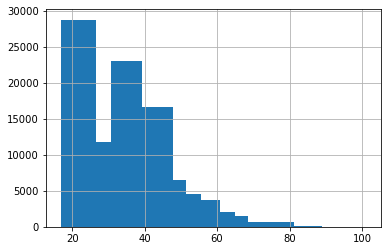

In [20]:
bins_methods = [ "auto", "fd", "doane", "scott", "stone", "rice", "sturges", "sqrt"]

# https://stackoverflow.com/a/18364570
def get_columns_bins(column_name):
    all_bins = []
  
    for method in bins_methods:
        start = datetime.now()
        hist, bin_edges = np.histogram(column_name,bins=method)
        all_bins.append(bin_edges)
        print("Method : {:<7} - Running Time : {:<5} - Number of bins : {:<5} - Head : {} - Tail : {}".format(method,str(datetime.now()-start), len(bin_edges), bin_edges[:3], bin_edges[-3:-1]))
    return all_bins



# https://stackoverflow.com/a/18364570
def get_clustering_bins(s, quantile=0.3, n_samples=None):
    
    series = s.dropna().values.reshape(-1, 1)
    
    bandwidth = estimate_bandwidth(series, quantile=quantile, n_samples=n_samples)
    clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(series)

    d = pd.DataFrame(columns=['data_column', 'label_column'])

    d['data_column'] = series.reshape(-1)
    d['label_column'] = clustering.labels_
    
    sorted_vals = d.groupby('label_column')['data_column'].max().sort_values().values
    bins = np.insert(sorted_vals, [0] , [series.min()-1])
    bins[-1] = bins[-1] + 1
    
    return bins, range(bins.size-1)


age_bins = []
age_bins = get_columns_bins(df_prepared.age)


age_bin,label = get_clustering_bins(pd.Series(age_bins[0]), quantile=0.2, n_samples=10)
df_prepared.age.hist(bins=age_bin)
age_bin


len(age_bin) , df_prepared.age.value_counts(bins=age_bin)
df_prepared['age_category'] = pd.cut(df_prepared.age, age_bin).cat.codes
df_prepared.head(5).append(df_prepared.tail(5))

In [21]:
test = df_prepared.copy()

In [22]:
merchant_cat_others = list(df_prepared["merchant_category"].value_counts()[df_prepared["merchant_category"].value_counts() < 800].index)
df_prepared["merchant_category"] = df_prepared["merchant_category"].apply(lambda x: "Other" if x in merchant_cat_others else x)


merchant_dict = {'Entertainment':1, 'Leisure, Sport & Hobby':2, 'Clothing & Shoes':4, 'Health & Beauty':6, 'Jewelry & Accessories':7, 
                 'Food & Beverage':9, 'Children Products':11, 'Home & Garden':13, 'Electronics':15, 'Automotive Products':17, 
                 'Intangible products':19, 'Erotic Materials':20}

df_prepared["merchant_group"] = df_prepared["merchant_group"].replace(merchant_dict.keys(), merchant_dict.values())
df_prepared = pd.concat([df_prepared, pd.get_dummies(df_prepared["name_in_email"],prefix="in_email_")], axis=1)
df_prepared.drop(columns=["name_in_email", "age"], axis=1, inplace=True)


le_merchant_category = LabelEncoder()
df_prepared["merchant_category"] = le_merchant_category.fit_transform(df_prepared["merchant_category"])

#df_prepared = df_prepared[df_prepared.columns.to_list()[-16:] + df_prepared.columns.to_list()[:-16]]

---

---

---

# Balance the data using SMOTE

---

---

---

In [23]:
df_default_null = df_prepared[pd.isnull(df_prepared["default"])].reset_index(drop=True)

In [24]:
df_analyze = df_prepared.dropna().reset_index(drop=True)

X = df_analyze.drop(columns=["uuid", "default"])
y = df_analyze["default"]
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['default'])
# we can Check the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['default']==0]))
print("Number of subscription",len(os_data_y[os_data_y['default']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['default']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['default']==1])/len(os_data_X))

Length of oversampled data is  124204
Number of no subscription in oversampled data 62102
Number of subscription 62102
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


---

---

---

# Random Forest

---

---

---

In [25]:
start = time.time()

n_estimators = [200, 700]
max_depth = [5, 8]
min_samples_split = [10, 100]
min_samples_leaf = [5, 10]
hyper_random = {"n_estimators":n_estimators,
              "max_depth":max_depth,
              "min_samples_split":min_samples_split,
              "min_samples_leaf":min_samples_leaf}

clf_rf_tuned = GridSearchCV(RandomForestClassifier(), hyper_random, 
                            cv = 5, verbose = 1, 
                            n_jobs = 4)
clf_rf_tuned.fit(os_data_X, os_data_y)
best_params_random = clf_rf_tuned.best_params_
print(best_params_random)


CV_clf_rf = RandomForestClassifier(max_depth=best_params_random["max_depth"],
                                   min_samples_leaf=best_params_random["min_samples_leaf"],
                                   min_samples_split=best_params_random["min_samples_split"],
                                   n_estimators= best_params_random["n_estimators"])
CV_clf_rf.fit(os_data_X, os_data_y)
y_test_predict_proba_random = CV_clf_rf.predict_proba(X_test)[:, 1]
yhat_random = CV_clf_rf.predict(X_test)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba_random, n_bins=10)


end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("\nÇalışma süresi: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.6min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 17.9min finished


{'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 700}

Çalışma süresi: 00:20:00.55


In [26]:
start = time.time()

# Create a corrected classifier.

clf_sigmoid = CalibratedClassifierCV(CV_clf_rf, cv=10, method='sigmoid')
clf_sigmoid.fit(os_data_X, os_data_y)
y_test_predict_proba_random_calibrated = clf_sigmoid.predict_proba(X_test)[:, 1]
yhat_calibrated_random = clf_sigmoid.predict(X_test)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba_random_calibrated, n_bins=10)


end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("\nÇalışma süresi: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


Çalışma süresi: 00:09:43.44


---

---

## Random Forest Results

---

---

In [27]:
print(classification_report(y_test, yhat_random))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94     26586
         1.0       0.07      0.52      0.12       407

    accuracy                           0.89     26993
   macro avg       0.53      0.70      0.53     26993
weighted avg       0.98      0.89      0.93     26993



---

---

## Calibrated Random Forest Results

---

---

In [28]:
print(classification_report(y_test, yhat_calibrated_random))

              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94     26586
         1.0       0.07      0.51      0.12       407

    accuracy                           0.89     26993
   macro avg       0.53      0.71      0.53     26993
weighted avg       0.98      0.89      0.93     26993



---

---

# Gaussian Naive Bayes

---

---

In [29]:
start = time.time()
# Uncalibrated
clf_nb = GaussianNB()
clf_nb.fit(os_data_X, os_data_y)
y_test_predict_proba_nb = clf_nb.predict_proba(X_test)[:, 1]
yhat_nb = clf_nb.predict(X_test)
fraction_of_positives_nb, mean_predicted_value_nb = calibration_curve(y_test, y_test_predict_proba_nb, n_bins=10)

#plt.plot(mean_predicted_value_nb, fraction_of_positives_nb, 's-', label='Uncalibrated')

# Calibrated
clf_sigmoid_nb = CalibratedClassifierCV(clf_nb, cv=10, method='isotonic')
clf_sigmoid_nb.fit(os_data_X, os_data_y)
y_test_predict_proba_nb_calib = clf_sigmoid_nb.predict_proba(X_test)[:, 1]
yhat_calibrated_nb = clf_sigmoid_nb.predict(X_test)
fraction_of_positives_nb_calib, mean_predicted_value_nb_calib = calibration_curve(y_test, y_test_predict_proba_nb_calib, n_bins=10)

#plt.plot(mean_predicted_value_nb_calib, fraction_of_positives_nb_calib, 's-', color='red', label='Calibrated (Isotonic)')

# Calibrated, Platt
clf_sigmoid_nb_calib_sig = CalibratedClassifierCV(clf_nb, cv=10, method='sigmoid')
clf_sigmoid_nb_calib_sig.fit(os_data_X, os_data_y)

y_test_predict_proba_nb_calib_platt = clf_sigmoid_nb_calib_sig.predict_proba(X_test)[:, 1]
yhat_calibrated_platt = clf_sigmoid_nb_calib_sig.predict(X_test)

fraction_of_positives_nb_calib_platt, mean_predicted_value_nb_calib_platt = calibration_curve(y_test, y_test_predict_proba_nb_calib_platt, n_bins=10)
#plt.plot(mean_predicted_value_nb_calib_platt, fraction_of_positives_nb_calib_platt, 's-', color='orange', label='Calibrated (Platt)')


#plt.plot([0, 1], [0, 1], '--', color='gray')

#sns.despine(left=True, bottom=True)
#plt.gca().xaxis.set_ticks_position('none')
#plt.gca().yaxis.set_ticks_position('none')
#plt.gca().legend()
#plt.title("$GaussianNB$ Sample Calibration Curve", fontsize=20); pass

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("\nÇalışma süresi: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


Çalışma süresi: 00:00:04.99


---

---

## Gaussian Naive Bayes Results

---

---

In [30]:
print(classification_report(y_test, yhat_nb))

              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     26586
         1.0       0.05      0.50      0.08       407

    accuracy                           0.84     26993
   macro avg       0.52      0.67      0.50     26993
weighted avg       0.98      0.84      0.90     26993



---

---

## Calibrated Gaussian Naive Bayes Results (Isotonic)

---

---

In [31]:
print(classification_report(y_test, yhat_calibrated_nb))

              precision    recall  f1-score   support

         0.0       0.99      0.71      0.83     26586
         1.0       0.03      0.61      0.06       407

    accuracy                           0.71     26993
   macro avg       0.51      0.66      0.44     26993
weighted avg       0.98      0.71      0.81     26993



---

---

## Calibrated Gaussian Naive Bayes Results (Sigmoid)

---

---

In [32]:
print(classification_report(y_test, yhat_calibrated_platt))

              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90     26586
         1.0       0.04      0.53      0.08       407

    accuracy                           0.82     26993
   macro avg       0.52      0.67      0.49     26993
weighted avg       0.98      0.82      0.89     26993



---

---

# NULL Results

In [33]:
df_default_null_keep = df_default_null[["uuid", "default"]]
df_default_null.drop(columns=["uuid", "default"], axis=1, inplace=True)

# Random Forest
y_predict_proba = CV_clf_rf.predict_proba(df_default_null)[:, 1]
yhat_predict = CV_clf_rf.predict(df_default_null)

# Calibrated Random Forest
y_predict_proba_crf = clf_sigmoid.predict_proba(df_default_null)[:, 1]
yhat_predict_crf = clf_sigmoid.predict(df_default_null)

#NB

y_predict_nb = clf_nb.predict_proba(df_default_null)[:, 1]
yhat_predict_nb = clf_nb.predict(df_default_null)

# Isotonic
y_predict_nb_isotonic = clf_sigmoid_nb.predict_proba(df_default_null)[:, 1]
yhat_predict_isotonic = clf_sigmoid_nb.predict(df_default_null)

# Sigmoid
y_predict_nb_sigmoid = clf_sigmoid_nb_calib_sig.predict_proba(df_default_null)[:, 1]
yhat_predict_sigmoid = clf_sigmoid_nb_calib_sig.predict(df_default_null)

In [34]:
nan_df_rf_nb = pd.concat([df_default_null_keep, 
           pd.Series(y_predict_proba, name="Random Forest Probability"),
           pd.Series(y_predict_proba_crf, name="Calibrated Random Forest Probability"),
           pd.Series(y_predict_nb, name="Naive Bayes"), 
           pd.Series(y_predict_nb_isotonic, name="Calibrated Naive Bayes (Isotonic)"),
           pd.Series(y_predict_nb_sigmoid, name="Calibrated Naive Bayes (Sigmoid)")], axis=1)

In [35]:
nan_df_rf_nb

,uuid,default,Random Forest Probability,Calibrated Random Forest Probability,Naive Bayes,Calibrated Naive Bayes (Isotonic),Calibrated Naive Bayes (Sigmoid)
0,6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7,NaN,0.207778,0.025884,1.723595e-16,0.078878,0.203904
1,f6f6d9f3-ef2b-4329-a388-c6a687f27e70,NaN,0.227243,0.040080,1.198108e-10,0.078878,0.203904
2,e9c39869-1bc5-4375-b627-a2df70b445ea,NaN,0.250519,0.038526,6.578015e-10,0.078878,0.203904
3,6beb88a3-9641-4381-beb6-c9a208664dd0,NaN,0.133105,0.012570,7.194286e-01,0.715523,0.726395
4,bb89b735-72fe-42a4-ba06-d63be0f4ca36,NaN,0.481870,0.463070,2.760891e-20,0.051489,0.203904
...,...,...,...,...,...,...,...
9995,5c03bc63-ea65-4ffd-aa7b-95ea9a46db34,NaN,0.274077,0.057775,6.593509e-23,0.051489,0.203904
9996,f8db22f4-9819-420c-abbc-9ddf1843176e,NaN,0.220784,0.040960,5.740623e-23,0.051489,0.203904
9997,b22e21ea-b1b2-4df3-b236-0ff6d5fdc0d8,NaN,0.467393,0.347172,1.128895e-01,0.389422,0.270498
9998,bafcab15-9898-479c-b729-c9dda7edb78f,NaN,0.507091,0.430070,1.450127e-01,0.405623,0.291641


# Train Results

In [36]:
#df_analyze_train
#df_default_train = df_analyze[X_train.index]["uuid", "default"]
df_default_train = df_analyze[df_analyze.index.isin(X_train.index.to_list())]

In [37]:
df_default_train.sort_index(inplace=True)
X_train.sort_index(inplace=True)

In [38]:
# Random Forest
y_predict_proba_train = CV_clf_rf.predict_proba(X_train)[:, 1]
yhat_predict_train = CV_clf_rf.predict(X_train)

# Calibrated Random Forest
y_predict_proba_crf_train = clf_sigmoid.predict_proba(X_train)[:, 1]
yhat_predict_crf_train = clf_sigmoid.predict(X_train)

#NB

y_predict_nb_train = clf_nb.predict_proba(X_train)[:, 1]
yhat_predict_nb_train = clf_nb.predict(X_train)

# Isotonic
y_predict_nb_isotonic_train = clf_sigmoid_nb.predict_proba(X_train)[:, 1]
yhat_predict_isotonic_train = clf_sigmoid_nb.predict(X_train)

# Sigmoid
y_predict_nb_sigmoid_train = clf_sigmoid_nb_calib_sig.predict_proba(X_train)[:, 1]
yhat_predict_sigmoid_train = clf_sigmoid_nb_calib_sig.predict(X_train)

In [39]:
train_df_rf_nb = pd.concat([df_default_train[["uuid", "default"]].reset_index(drop=True), 
           pd.Series(y_predict_proba_train, name="Random Forest Probability").reset_index(drop=True),
           pd.Series(y_predict_proba_crf_train, name="Calibrated Random Forest Probability").reset_index(drop=True),
           pd.Series(y_predict_nb_train, name="Naive Bayes").reset_index(drop=True), 
           pd.Series(y_predict_nb_isotonic_train, name="Calibrated Naive Bayes (Isotonic)").reset_index(drop=True),
           pd.Series(y_predict_nb_sigmoid_train, name="Calibrated Naive Bayes (Sigmoid)").reset_index(drop=True)], axis=1)

# Test Results

In [40]:
#df_analyze_train
#df_default_train = df_analyze[X_train.index]["uuid", "default"]
df_default_test = df_analyze[df_analyze.index.isin(X_test.index.to_list())]

In [41]:
df_default_test.sort_index(inplace=True)
X_test.sort_index(inplace=True)

In [42]:
# Random Forest
y_predict_proba_test = CV_clf_rf.predict_proba(X_test)[:, 1]
yhat_predict_test = CV_clf_rf.predict(X_test)

# Calibrated Random Forest
y_predict_proba_crf_test = clf_sigmoid.predict_proba(X_test)[:, 1]
yhat_predict_crf_test = clf_sigmoid.predict(X_test)

#NB

y_predict_nb_test = clf_nb.predict_proba(X_test)[:, 1]
yhat_predict_nb_test = clf_nb.predict(X_test)

# Isotonic
y_predict_nb_isotonic_test = clf_sigmoid_nb.predict_proba(X_test)[:, 1]
yhat_predict_isotonic_test = clf_sigmoid_nb.predict(X_test)

# Sigmoid
y_predict_nb_sigmoid_test = clf_sigmoid_nb_calib_sig.predict_proba(X_test)[:, 1]
yhat_predict_sigmoid_test = clf_sigmoid_nb_calib_sig.predict(X_test)

In [43]:
test_df_rf_nb = pd.concat([df_default_test[["uuid", "default"]].reset_index(drop=True), 
                          pd.Series(y_predict_proba_test, name="Random Forest Probability").reset_index(drop=True),
                          pd.Series(y_predict_proba_crf_test, name="Calibrated Random Forest Probability").reset_index(drop=True),
                          pd.Series(y_predict_nb_test, name="Naive Bayes").reset_index(drop=True),
                          pd.Series(y_predict_nb_isotonic_test, name="Calibrated Naive Bayes (Isotonic)").reset_index(drop=True),
                          pd.Series(y_predict_nb_sigmoid_test, name="Calibrated Naive Bayes (Sigmoid)").reset_index(drop=True)], axis=1)

---

---

# Concat all results

---

---

In [44]:
df_all_results = pd.concat([nan_df_rf_nb, train_df_rf_nb, test_df_rf_nb], axis=0, ignore_index=True)

# SVM

---

---

In [45]:
"""
start = time.time()
#hyper_svm = {"kernel": ["linear", "poly", "rbf", "sigmoid"],
#           "C": [1, 100, 1000],
#           "gamma": [1, 0.1, 0.00001]}


hyper_svm = {"kernel": ["rbf"],
           "C": [1],
           "gamma": [1]}
clf_svm_tuned = GridSearchCV(SVC(probability=True), 
                             hyper_svm,
                             cv=3,
                             verbose=1,
                             n_jobs=6)

clf_svm_tuned.fit(os_data_X, os_data_y)
best_params_svm = clf_svm_tuned.best_params_
print(best_params_svm)


CV_clf_svm = SVC(kernel=best_params_svm["kernel"],
                 C=best_params_svm["C"],
                 gamma=best_params_svm["gamma"],
                 probability=True)

CV_clf_svm.fit(os_data_X, os_data_y)
y_test_predict_proba_svm = CV_clf_svm.predict_proba(X_test)[:, 1]
yhat_svm = CV_clf_svm.predict(X_test)
fraction_of_positives_svm, mean_predicted_value_svm = calibration_curve(y_test, y_test_predict_proba_svm, n_bins=10)


end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("\nÇalışma süresi: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
"""

'\nstart = time.time()\n#hyper_svm = {"kernel": ["linear", "poly", "rbf", "sigmoid"],\n#           "C": [1, 100, 1000],\n#           "gamma": [1, 0.1, 0.00001]}\n\n\nhyper_svm = {"kernel": ["rbf"],\n           "C": [1],\n           "gamma": [1]}\nclf_svm_tuned = GridSearchCV(SVC(probability=True), \n                             hyper_svm,\n                             cv=3,\n                             verbose=1,\n                             n_jobs=6)\n\nclf_svm_tuned.fit(os_data_X, os_data_y)\nbest_params_svm = clf_svm_tuned.best_params_\nprint(best_params_svm)\n\n\nCV_clf_svm = SVC(kernel=best_params_svm["kernel"],\n                 C=best_params_svm["C"],\n                 gamma=best_params_svm["gamma"],\n                 probability=True)\n\nCV_clf_svm.fit(os_data_X, os_data_y)\ny_test_predict_proba_svm = CV_clf_svm.predict_proba(X_test)[:, 1]\nyhat_svm = CV_clf_svm.predict(X_test)\nfraction_of_positives_svm, mean_predicted_value_svm = calibration_curve(y_test, y_test_predict_pro

In [46]:
"""
start = time.time()
# Create a corrected classifier.
clf_sigmoid_svm = CalibratedClassifierCV(CV_clf_svm, cv=10, method='sigmoid')
clf_sigmoid_svm.fit(os_data_X, os_data_y)
y_test_predict_proba_svm_calibrated = clf_sigmoid_svm.predict_proba(X_test)[:, 1]
yhat_calibrated_svm = clf_sigmoid_svm.predict(X_test)
fraction_of_positives_svm_calibrated, mean_predicted_value_svm_calibrated = calibration_curve(y_test, y_test_predict_proba_svm_calibrated, n_bins=10)

#plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Calibrated (Platt)')
#plt.plot([0, 1], [0, 1], '--', color='gray')

#sns.despine(left=True, bottom=True)
#plt.gca().xaxis.set_ticks_position('none')
#plt.gca().yaxis.set_ticks_position('none')
#plt.gca().legend()
#plt.title("$SVM$ Sample Calibration Curve", fontsize=20); pass

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("\nÇalışma süresi: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
"""

'\nstart = time.time()\n# Create a corrected classifier.\nclf_sigmoid_svm = CalibratedClassifierCV(CV_clf_svm, cv=10, method=\'sigmoid\')\nclf_sigmoid_svm.fit(os_data_X, os_data_y)\ny_test_predict_proba_svm_calibrated = clf_sigmoid_svm.predict_proba(X_test)[:, 1]\nyhat_calibrated_svm = clf_sigmoid_svm.predict(X_test)\nfraction_of_positives_svm_calibrated, mean_predicted_value_svm_calibrated = calibration_curve(y_test, y_test_predict_proba_svm_calibrated, n_bins=10)\n\n#plt.plot(mean_predicted_value, fraction_of_positives, \'s-\', label=\'Calibrated (Platt)\')\n#plt.plot([0, 1], [0, 1], \'--\', color=\'gray\')\n\n#sns.despine(left=True, bottom=True)\n#plt.gca().xaxis.set_ticks_position(\'none\')\n#plt.gca().yaxis.set_ticks_position(\'none\')\n#plt.gca().legend()\n#plt.title("$SVM$ Sample Calibration Curve", fontsize=20); pass\n\nend = time.time()\nhours, rem = divmod(end-start, 3600)\nminutes, seconds = divmod(rem, 60)\nprint("\nÇalışma süresi: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hour

---

---

## SVM Results

---

---

In [47]:
"""
classification_report(y_test, yhat_svm)
"""

'\nclassification_report(y_test, yhat_svm)\n'

---

---

## Calibrated SVM Results

---

---

In [48]:
"""
classification_report(y_test, yhat_calibrated_svm)
"""

'\nclassification_report(y_test, yhat_calibrated_svm)\n'

In [49]:
df_all_results.to_csv("../data/Probability_All_Results.csv", index=False)

In [56]:
conn = sql.connect("df_all_results.db")
df_all_results.to_sql("../data/df_all_results", conn)

ValueError: Table '../data/df_all_results' already exists.